In [1]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

In [4]:
# from google.colab import drive
# drive.mount("/content/gdrive")
path_data = "C:\\Users\\khush\\Desktop\\CV-Assignments\\Refresher-Module\\data"

# **Dataset Formation**

In [5]:
train_size = int(2000*0.7)
test_size = int(2000*0.15)
val_size = int(2000*0.15)

In [6]:
g = torch.Generator()
g.manual_seed(42)

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((64, 64))])

batch_size = 512

dataset = torchvision.datasets.ImageFolder(
    root=path_data,
    transform=transform
)
dataset_size = len(dataset)
print(dataset_size)

indices = list(range(dataset_size))
np.random.shuffle(indices)

test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

trainloader = torch.utils.data.DataLoader(dataset, sampler = train_sampler, batch_size=batch_size)
valloader = torch.utils.data.DataLoader(dataset, sampler = val_sampler, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(dataset, sampler = test_sampler, batch_size=batch_size)

print(dataset.class_to_idx)

2000
{'Parasitized': 0, 'Uninfected': 1}


In [13]:
print("Length of train: ", len(train_index))
print("Length of val: ", len(val_index))
print("Length of test: ", len(test_index))

Length of train:  1400
Length of val:  300
Length of test:  300


In [14]:
dataset_size

2000

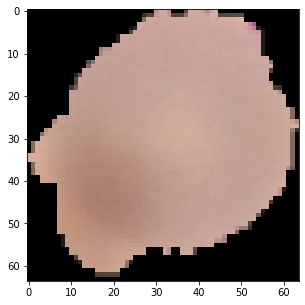

tensor(0)


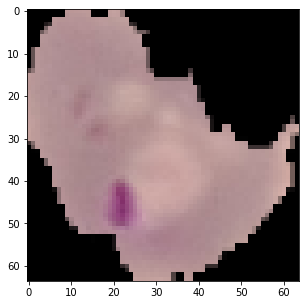

tensor(0)


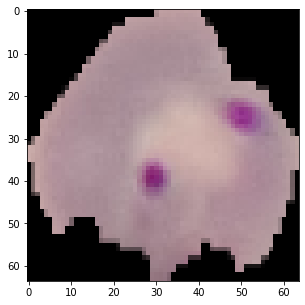

tensor(0)


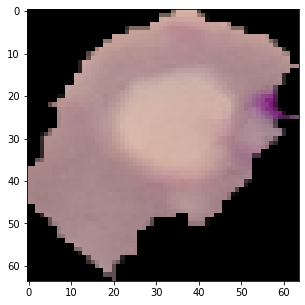

tensor(0)


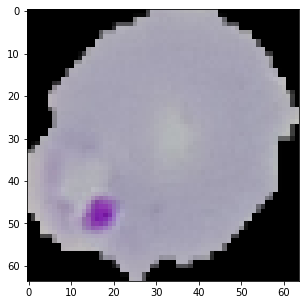

tensor(0)


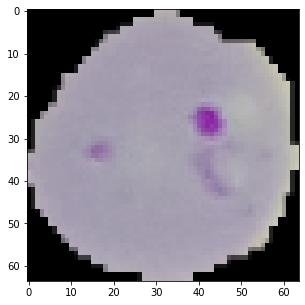

tensor(0)


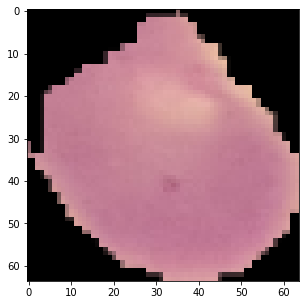

tensor(1)


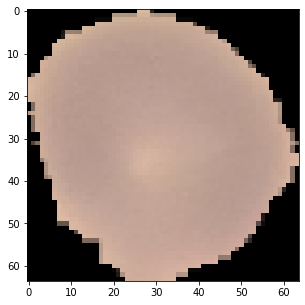

tensor(1)


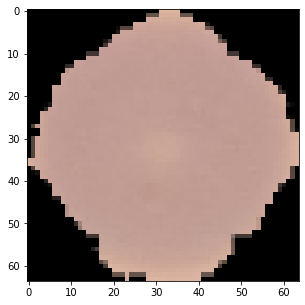

tensor(1)


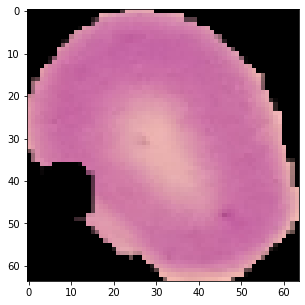

tensor(1)


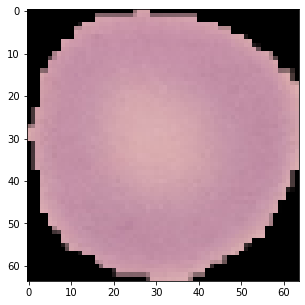

tensor(1)


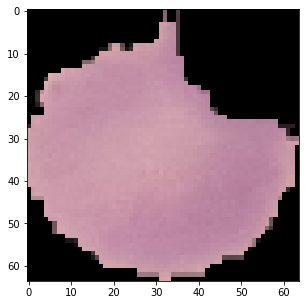

tensor(1)


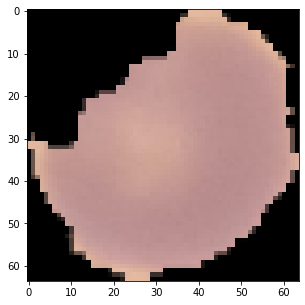

tensor(1)


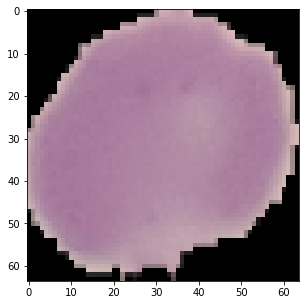

tensor(1)


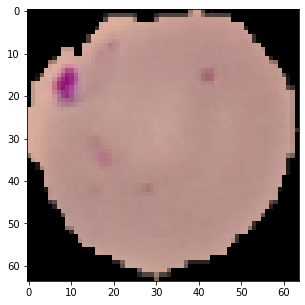

tensor(0)


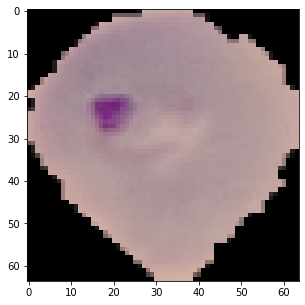

tensor(0)


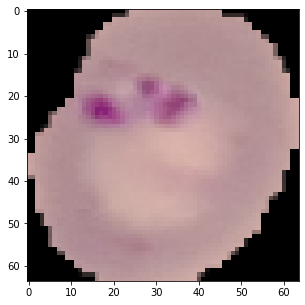

tensor(0)


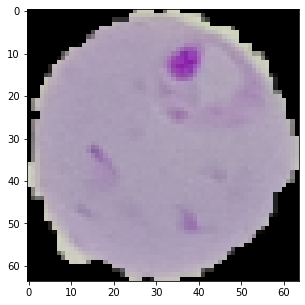

tensor(0)


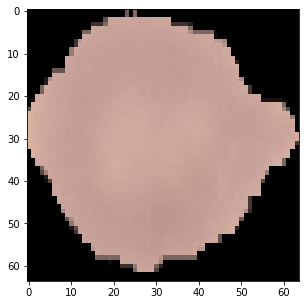

tensor(1)


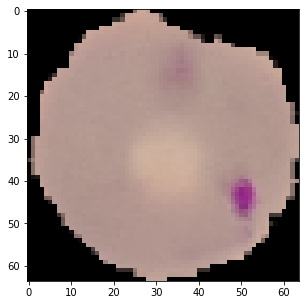

tensor(0)


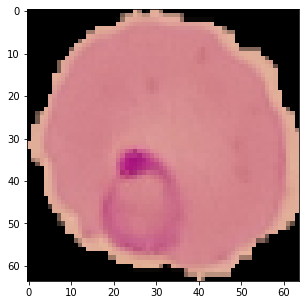

tensor(0)


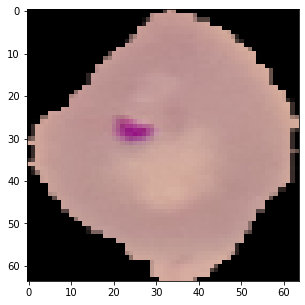

tensor(0)


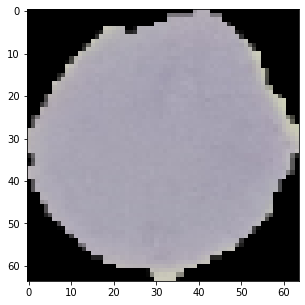

tensor(1)


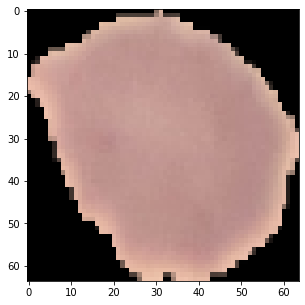

tensor(1)


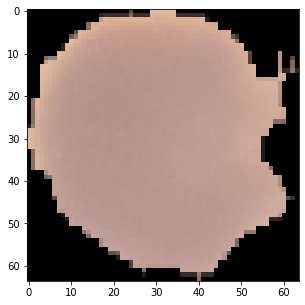

tensor(1)


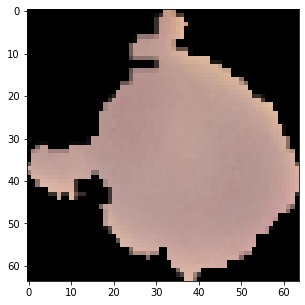

tensor(1)


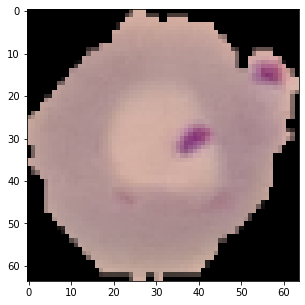

tensor(0)


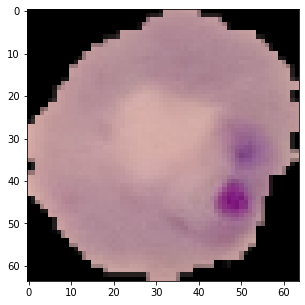

tensor(0)


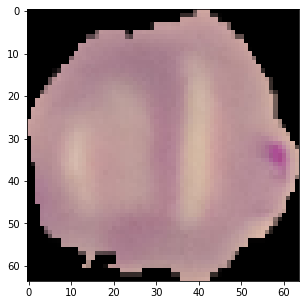

tensor(0)


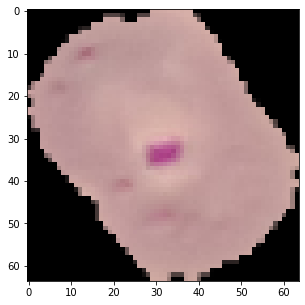

tensor(0)


In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

def imshow(img):
    plt.figure(figsize=(5, 5))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i in range(30):
  imshow(images[i])
  print(labels[i])

In [16]:
help(dataiter)

Help on _SingleProcessDataLoaderIter in module torch.utils.data.dataloader object:

class _SingleProcessDataLoaderIter(_BaseDataLoaderIter)
 |  _SingleProcessDataLoaderIter(loader)
 |  
 |  Method resolution order:
 |      _SingleProcessDataLoaderIter
 |      _BaseDataLoaderIter
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, loader)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from _BaseDataLoaderIter:
 |  
 |  __getstate__(self)
 |  
 |  __iter__(self) -> '_BaseDataLoaderIter'
 |  
 |  __len__(self) -> int
 |  
 |  __next__(self) -> Any
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from _BaseDataLoaderIter:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



### **Defining the model architecture**

In [17]:
class Model(nn.Module):
    def __init__(self,mode="default",drops="none"):
      
        super().__init__()

        #conv2d main args = in_channel, out_channel, kernel size, stride, padding
        #MaxPool2d main args = kernel size, stride

        self.conv1 = nn.Conv2d(3, 5, 9)
        self.conv2 = nn.Conv2d(5, 7, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(7, 10, 3)
        self.fc1 = nn.Linear(10 * 23 * 23, 1)
        self.drop = nn.Dropout2d(0.2)
        self.sig = nn.Sigmoid()
        self.drops = drops

        if mode=="Zero":
          torch.nn.init.zeros_(self.conv1.weight)
          torch.nn.init.zeros_(self.conv2.weight)
          torch.nn.init.zeros_(self.conv3.weight)
          torch.nn.init.zeros_(self.fc1.weight)


        elif mode=="Random":
          torch.nn.init.normal_(self.conv1.weight)
          torch.nn.init.normal_(self.conv2.weight)
          torch.nn.init.normal_(self.conv3.weight)
          torch.nn.init.normal_(self.fc1.weight)

        elif mode=="He":
          torch.nn.init.kaiming_uniform_(self.conv1.weight)
          torch.nn.init.kaiming_uniform_(self.conv2.weight)
          torch.nn.init.kaiming_uniform_(self.conv3.weight)
          torch.nn.init.kaiming_uniform_(self.fc1.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.conv3(x)
        
        if self.drops=="after_conv":
          x = self.drop(x)
        x = torch.flatten(x, 1) 
        x = self.fc1(x)

        if self.drops=="after_fc":
          x = self.drop(x)
        
        return self.sig(x)
      
    def get_features(self, x):
        x = self.conv1(x)
        x = self.pool(self.conv2(x))
        x = self.conv3(x)
        
        x = torch.flatten(x, 1) 
        return x
      
    def get_outs(self, x):

        x = self.conv1(x)
        y = self.pool(self.conv2(x))
        z = self.conv3(y)

        return x,y,z

    
def my_loss(outputs,labels):
  loss = torch.mean(-labels*torch.log(outputs)-(1-labels)*torch.log((1-outputs)))
  return loss
    
model = Model("He")

# **Optimizer and Loss function**

In [18]:
# criterion =  nn.BCELoss()
criterion =  my_loss
##nn.CrossEntropyLoss()
#nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
#torch.optim.SGD(net.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)

# **Training and testing on validation set**

In [20]:
total_loss_train = []
total_loss_validation = []
lambda1=0.5
regu="none"

for epoch in range(20):  
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        labels = labels.reshape(-1,1)
        labels=labels.float()
        
        loss = criterion(outputs, labels)
        
        if regu=="L1":
          all_params = torch.cat([x.view(-1) for x in model.parameters()])
          l1_reg = lambda1 * torch.norm(all_params, 1)
          loss += l1_reg
        
        if regu=="L2":
          all_params = torch.cat([x.view(-1) for x in model.parameters()])
          l2_reg = lambda1 * torch.norm(all_params, 2)**2
          loss += l2_reg

        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        
        print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1

    batch_loss_train/=num_batches
    total_loss_train.append(batch_loss_train)
    correct = 0
    total = 0
    cnt=0
    with torch.no_grad():

      for data in valloader:
          # print("s")
          images, labels = data
          outputs = model(images)
          total += labels.size(0)
          cnt+=1
          labels = labels.float()
          loss_val = criterion(outputs, labels)
          
          batch_loss_val += loss_val.item()
          outputs = [1 if x>0.5 else 0 for x in outputs]
          outputs = torch.Tensor(outputs)
          
          correct += (outputs == labels).sum().item()
      total_loss_validation += [batch_loss_val/cnt]
      print("Validation loss is ",batch_loss_val/cnt)
    print(correct/total)

print('Finished Training')

[epoch, batch] =  [1,     0] loss: 0.471677
[epoch, batch] =  [1,     1] loss: 0.483665
[epoch, batch] =  [1,     2] loss: 0.464953
Validation loss is  0.9787202477455139
0.72
[epoch, batch] =  [2,     0] loss: 0.468106
[epoch, batch] =  [2,     1] loss: 0.459622
[epoch, batch] =  [2,     2] loss: 0.493954
Validation loss is  0.9764166474342346
0.73
[epoch, batch] =  [3,     0] loss: 0.472563
[epoch, batch] =  [3,     1] loss: 0.445077
[epoch, batch] =  [3,     2] loss: 0.470208
Validation loss is  0.9995493292808533
0.7033333333333334
[epoch, batch] =  [4,     0] loss: 0.438045
[epoch, batch] =  [4,     1] loss: 0.462377
[epoch, batch] =  [4,     2] loss: 0.482718
Validation loss is  0.9651932120323181
0.73
[epoch, batch] =  [5,     0] loss: 0.445105
[epoch, batch] =  [5,     1] loss: 0.449188
[epoch, batch] =  [5,     2] loss: 0.454113
Validation loss is  1.0037243366241455
0.7
[epoch, batch] =  [6,     0] loss: 0.477673
[epoch, batch] =  [6,     1] loss: 0.405748
[epoch, batch] =  [

# **loss plots**

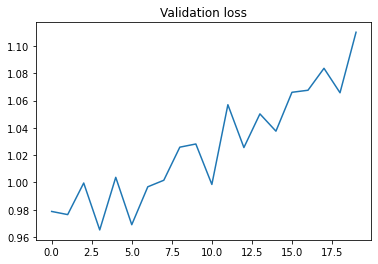

In [21]:
import matplotlib.pyplot as plt
plt.plot(total_loss_validation)
plt.title("Validation loss")
plt.show()


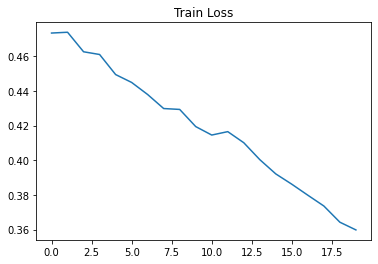

In [22]:
plt.plot(total_loss_train)
plt.title("Train Loss")
plt.show()

# **Saving and loading the saved model**

In [26]:
# save pickle files
filename = 'C:\\Users\\khush\\Desktop\\CV-Assignments\\Refresher-Module\\data\\cnn.sav'
pickle.dump(model, open(filename, 'wb')) 

In [27]:
loaded_model = pickle.load(open(filename, 'rb'))

# **Checking class distribution**

In [31]:
print(np.unique(labels, return_counts=True))

(array([0., 1.], dtype=float32), array([154, 146], dtype=int64))


# **Testing on the test set**

In [32]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = loaded_model(images)
        outputs = [1 if x>0.5 else 0 for x in outputs]
        outputs = torch.Tensor(outputs)
        total += labels.size(0)
        print(classification_report(outputs, labels))
        correct += (outputs == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

              precision    recall  f1-score   support

         0.0       0.62      0.79      0.69       118
         1.0       0.83      0.69      0.75       182

    accuracy                           0.73       300
   macro avg       0.73      0.74      0.72       300
weighted avg       0.75      0.73      0.73       300

Accuracy of the network on the test images: 72 %


# **Features visualization using T-SNE plot**

In [33]:
labels = None
features = None
with torch.no_grad():
    for data in testloader:
        images, labels = data
        features = loaded_model.get_features(images)
      
print(features)


tensor([[-2.4044, -1.5063, -1.4352,  ..., -1.4425, -3.3090, -2.7681],
        [ 1.3391,  1.8843, -0.4045,  ..., -1.8298, -3.0736, -1.9048],
        [-0.5591,  0.4457,  0.4911,  ..., -3.1129, -3.0003, -3.7237],
        ...,
        [-0.2053, -0.2801, -0.7276,  ...,  0.2263,  0.4705, -0.8216],
        [ 2.0946,  2.6340,  2.0102,  ...,  0.5653,  0.1787, -0.6341],
        [-0.1628, -1.2750, -1.4278,  ..., -2.5490, -2.8277, -0.7144]])


In [34]:
final_features = np.array(features)
tsne = manifold.TSNE(n_components=2, random_state=42)

# fit and transform
tsne_features = tsne.fit_transform(final_features)

c:\Users\khush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\khush\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [35]:
final_labels = np.array(labels)
tsne_df = pd.DataFrame(columns=['F1', 'F2', 'target'], data=np.column_stack((tsne_features, final_labels)))

# cast targets column to int
tsne_df.loc[:, 'target'] = tsne_df.target.astype(int)
tsne_df.head()

,F1,F2,target
0,-4.431122,2.721163,1
1,2.008109,-4.429114,1
2,5.342645,11.878293,1
3,-10.163003,9.767506,0
4,10.434082,-2.547050,0


Text(0.5, 1.0, 'TSNE Plot of test features')

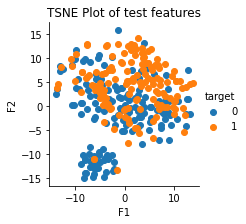

In [36]:
grid = sns.FacetGrid(tsne_df, hue="target")
grid.map(plt.scatter, 'F1', 'F2').add_legend()
plt.title("TSNE Plot of test features")

# **Output layer sizes of the CNN**

In [37]:
with torch.no_grad():
    for data in testloader:
        images, labels = data
        x,y,z = loaded_model.get_outs(images)
        print("Size after conv1 layer: ", x.size())
        print("Size after conv2 layer followed by pooling: ", y.size())
        print("Size after conv3 layer: ", z.size())

Size after conv1 layer:  torch.Size([300, 5, 56, 56])
Size after conv2 layer followed by pooling:  torch.Size([300, 7, 25, 25])
Size after conv3 layer:  torch.Size([300, 10, 23, 23])
